Ideas on how to merge data
First merge the data I have. do feature engineering later

**Features**

*Census* - monthly aggregated - should be easy to include an offset in a poisson regression
*Mag* - daily, will have a lot of nans, 
*SpaceWeather* - daily
*Winds* - daily
*Chlorophyll* - daily
*Tides* - daily

**Targets**

*Stranding* 
    - total
    - split by species

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from seaborn import heatmap
from matplotlib import rcParams
from cmocean import cm as cmo
from datetime import datetime as dt

In [3]:
%matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14

#### <u>Stranding data</u>

In [4]:
dfStrand = pd.read_pickle('../PklJar/Data/dfStrandDailyCleanCompact.pkl')
dfStrand.rename(columns={'NUM_ANIMALS': 'Total_Stranded'},
                inplace=True)
dfStrand.columns = dfStrand.columns.str.replace('SPECIES', 'Stranded')
begin_date = dfStrand.index[0].to_pydatetime().strftime('%Y-%m-%d')
end_date = dfStrand.index[-1].to_pydatetime().strftime('%Y-%m-%d')

#### <u>Census data</u>

In [5]:
dfCensus = pd.read_pickle('../PklJar/Data/Census/dfCensus_Cape_Cod_6spp.pkl')
dfCensus = dfCensus.filter(regex='ount')
dfCensus.columns = dfCensus.columns.str.replace('count' ,'census')
dfCensus.rename(columns={'Sum_Counts': 'AllSpp_census'}, inplace=True)

In [6]:
# take rolling sum to account for possible presence of animals
# within the range equivalent to 1 week of cruising from stranding site
dfCensusWeeklyRollingSum = dfCensus.rolling('7D').sum()

In [7]:
dfCensusWeeklyRollingSum.describe().T

,count,mean,std,min,25%,50%,75%,max
Stene_census,5844.0,12.557837,82.916559,0.0,0.0,0.0,0.0,1348.0
Gramp_census,5844.0,5.306639,23.811753,0.0,0.0,0.0,0.0,365.0
Delph_census,5844.0,76.796030,254.405741,0.0,0.0,0.0,30.0,3010.0
Lagen_census,5844.0,86.090178,227.404227,0.0,0.0,3.0,60.0,2956.0
Tursi_census,5844.0,96.757871,240.473984,0.0,0.0,3.0,71.0,2473.0
Globi_census,5844.0,11.307324,30.357722,0.0,0.0,0.0,5.0,320.0
AllSpp_census,5844.0,288.815880,491.867365,0.0,8.0,84.0,346.5,3587.0


In [8]:
dfCensusWeeklyRollingSum = dfCensusWeeklyRollingSum.loc[begin_date: end_date]

In [9]:
# merge stranding and census data
dfMerged = dfStrand.merge(dfCensusWeeklyRollingSum, right_index=True,
                          left_index=True, how='outer')
dfMerged.head(2).T

REPORT_DATE,1999-03-07 00:00:00,1999-03-08 00:00:00
Total_Stranded,11.0,0.0
Stranded_Delphinus delphis,0.0,0.0
Stranded_Globicephala melas,0.0,0.0
Stranded_Grampus griseus,0.0,0.0
Stranded_Lagenorhynchus acutus,6.0,0.0
Stranded_Stenella coeruleoalba,0.0,0.0
Stranded_Tursiops truncatus,0.0,0.0
CONDITION_CODE_1,4.0,0.0
CONDITION_CODE_2,2.0,0.0
CONDITION_CODE_3,0.0,0.0


In [10]:
dfMerged.tail(2).T

REPORT_DATE,2014-12-03 00:00:00,2014-12-04 00:00:00
Total_Stranded,0.0,2.0
Stranded_Delphinus delphis,0.0,2.0
Stranded_Globicephala melas,0.0,0.0
Stranded_Grampus griseus,0.0,0.0
Stranded_Lagenorhynchus acutus,0.0,0.0
Stranded_Stenella coeruleoalba,0.0,0.0
Stranded_Tursiops truncatus,0.0,0.0
CONDITION_CODE_1,0.0,0.0
CONDITION_CODE_2,0.0,2.0
CONDITION_CODE_3,0.0,0.0


Splitting up features from labels and pickling both dataFrames:

In [11]:
dfFeatures = dfMerged.filter(regex='census', axis=1)
dfLabels = dfMerged.filter(regex='Stranded', axis=1)

In [12]:
dfFeatures.to_pickle('../PklJar/Data/DFFEATURES.pkl')
dfLabels.to_pickle('../PklJar/Data/DFLABELS.pkl')

#### <u>Frederick and Ottawa Magnetic Data</u>

In [13]:
# Pulling in Mag:
dfMag = pd.read_pickle('../PklJar/Data/dfMagDaily.pkl')
dfMag.columns = ['Mag_%s' %col for col in dfMag.columns]

In [14]:
dfMag_shift_1d = dfMag.shift(periods=1, freq='D')
dfMag = dfMag.merge(dfMag_shift_1d, left_index=True, right_index=True, suffixes=('', '_1DLag'))

In [15]:
dfMag = dfMag.loc[begin_date: end_date]
dfMag.head()

,Mag_FRDH,Mag_FRDV,Mag_OTTH,Mag_OTTV,Mag_FRDH_1DLag,Mag_FRDV_1DLag,Mag_OTTH_1DLag,Mag_OTTV_1DLag
DATE_TIME,,,,,,,,
1999-03-07,20973.912083,49185.560903,17437.979625,53532.025069,21537.349028,49322.660069,17455.559320,53534.403056
1999-03-08,20990.983472,49181.313264,17456.633064,53532.310625,20973.912083,49185.560903,17437.979625,53532.025069
1999-03-09,21094.763472,49251.502500,17449.245519,53528.842847,20990.983472,49181.313264,17456.633064,53532.310625
1999-03-10,20977.871806,49174.146944,17433.556173,53506.013542,21094.763472,49251.502500,17449.245519,53528.842847
1999-03-11,20882.766944,49104.043333,17456.700552,53524.094653,20977.871806,49174.146944,17433.556173,53506.013542


In [16]:
dfFeatures = dfFeatures.merge(dfMag, how='outer', left_index=True, right_index=True)

In [18]:
dfFeatures.head(2).T

REPORT_DATE,1999-03-07 00:00:00,1999-03-08 00:00:00
Stene_census,0.000000,0.000000
Gramp_census,0.000000,0.000000
Delph_census,0.000000,0.000000
Lagen_census,102.000000,62.000000
Tursi_census,0.000000,0.000000
Globi_census,0.000000,0.000000
AllSpp_census,102.000000,62.000000
Mag_FRDH,20973.912083,20990.983472
Mag_FRDV,49185.560903,49181.313264
Mag_OTTH,17437.979625,17456.633064


In [19]:
dfFeatures.to_pickle('../PklJar/Data/DFFEATURES.pkl')

#### <u>Space Weather</u>

In [20]:
# Pulling in SpaceWeather
dfSW = pd.read_pickle('../PklJar/Data/dfSpaceWeatherDaily.pkl')
dfSW_shift1d = dfSW.shift(1, freq='D')
dfSW = dfSW.merge(dfSW_shift1d, left_index=True, right_index=True, suffixes=('', '_1DLag'))

In [21]:
dfSW = dfSW.loc[begin_date: end_date]

In [22]:
dfFeatures = dfFeatures.merge(dfSW, how='outer',
                              left_index=True, right_index=True)

In [23]:
dfFeatures.head(2).T

REPORT_DATE,1999-03-07 00:00:00,1999-03-08 00:00:00
Stene_census,0.000000,0.000000
Gramp_census,0.000000,0.000000
Delph_census,0.000000,0.000000
Lagen_census,102.000000,62.000000
Tursi_census,0.000000,0.000000
Globi_census,0.000000,0.000000
AllSpp_census,102.000000,62.000000
Mag_FRDH,20973.912083,20990.983472
Mag_FRDV,49185.560903,49181.313264
Mag_OTTH,17437.979625,17456.633064


In [24]:
dfFeatures.to_pickle('../PklJar/Data/DFFEATURES.pkl')

#### Tidal Data

In [25]:
dfTides = pd.read_pickle('../PklJar/Data/dfTidesDaily.pkl')
dfTides = dfTides.filter(regex='Pred_m')
dfTides_shift1d = dfTides.shift(1, freq='D')
dfTides = dfTides.merge(dfTides_shift1d, left_index=True, right_index=True,
                        suffixes=('', '_1DLag'))

In [26]:
dfTides = dfTides.loc[begin_date: end_date]

In [27]:
dfTides.head(2).T

Date_Time,1999-03-07 00:00:00,1999-03-08 00:00:00
Pred_min,0.150,0.240
Pred_max,2.860,2.790
Pred_med,1.495,1.490
Pred_min_1DLag,0.070,0.150
Pred_max_1DLag,2.920,2.860
Pred_med_1DLag,1.500,1.495


In [28]:
dfFeatures = dfFeatures.merge(dfTides, 'outer', left_index=True, right_index=True)

In [29]:
dfFeatures.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5752 entries, 1999-03-07 to 2014-12-04
Freq: D
Data columns (total 33 columns):
Stene_census                 5752 non-null float64
Gramp_census                 5752 non-null float64
Delph_census                 5752 non-null float64
Lagen_census                 5752 non-null float64
Tursi_census                 5752 non-null float64
Globi_census                 5752 non-null float64
AllSpp_census                5752 non-null float64
Mag_FRDH                     5744 non-null float64
Mag_FRDV                     5732 non-null float64
Mag_OTTH                     5414 non-null float64
Mag_OTTV                     5400 non-null float64
Mag_FRDH_1DLag               5744 non-null float64
Mag_FRDV_1DLag               5732 non-null float64
Mag_OTTH_1DLag               5415 non-null float64
Mag_OTTV_1DLag               5401 non-null float64
Kp_index                     5752 non-null float64
Sunspot_No                   5752 non-null float64


In [30]:
dfFeatures.to_pickle('../PklJar/Data/DFFEATURES.pkl')

#### <u>Wind Data</u>

In [31]:
dfWind = pd.read_pickle('../PklJar/Data/dfDailyWind.pkl')

In [32]:
dfWind_shift_1d = dfWind.shift(periods=1, freq='D')
dfWind_shift_1W = dfWind.shift(periods=7, freq='D')
dfWind_shift_1M = dfWind.shift(periods=30, freq='D')

In [35]:
dfWind = dfWind.merge(dfWind_shift_1d, left_index=True, right_index=True, suffixes=('', '_1DLag'))
dfWind = dfWind.merge(dfWind_shift_1W, left_index=True, right_index=True, suffixes=('', '_1WLag'))
dfWind = dfWind.merge(dfWind_shift_1M, left_index=True, right_index=True, suffixes=('', '_1MLag'))

In [42]:
dfWind.head(2).T

date,1999-01-31 00:00:00,1999-02-01 00:00:00
EasterlyWS,-2.685939,-6.103224
SoutherlyWS,7.333107,-4.351456
WTMP,3.241667,3.191667
WVHT,2.046667,1.115000
APD,5.646250,5.165833
DPD,7.269583,7.999167
EasterlyWS_1DLag,-2.499490,-2.685939
SoutherlyWS_1DLag,5.066225,7.333107
WTMP_1DLag,3.300000,3.241667
WVHT_1DLag,0.945417,2.046667


In [43]:
dfWind = dfWind.loc[begin_date: end_date]

In [44]:
dfFeatures = dfFeatures.merge(dfWind, 'outer', left_index=True, right_index=True)

In [45]:
dfFeatures.head(2).T

REPORT_DATE,1999-03-07 00:00:00,1999-03-08 00:00:00
Stene_census,0.000000,0.000000
Gramp_census,0.000000,0.000000
Delph_census,0.000000,0.000000
Lagen_census,102.000000,62.000000
Tursi_census,0.000000,0.000000
Globi_census,0.000000,0.000000
AllSpp_census,102.000000,62.000000
Mag_FRDH,20973.912083,20990.983472
Mag_FRDV,49185.560903,49181.313264
Mag_OTTH,17437.979625,17456.633064


In [46]:
dfFeatures.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5752 entries, 1999-03-07 to 2014-12-04
Freq: D
Data columns (total 57 columns):
Stene_census                 5752 non-null float64
Gramp_census                 5752 non-null float64
Delph_census                 5752 non-null float64
Lagen_census                 5752 non-null float64
Tursi_census                 5752 non-null float64
Globi_census                 5752 non-null float64
AllSpp_census                5752 non-null float64
Mag_FRDH                     5744 non-null float64
Mag_FRDV                     5732 non-null float64
Mag_OTTH                     5414 non-null float64
Mag_OTTV                     5400 non-null float64
Mag_FRDH_1DLag               5744 non-null float64
Mag_FRDV_1DLag               5732 non-null float64
Mag_OTTH_1DLag               5415 non-null float64
Mag_OTTV_1DLag               5401 non-null float64
Kp_index                     5752 non-null float64
Sunspot_No                   5752 non-null float64


In [47]:
dfFeatures.to_pickle('../PklJar/Data/DFFEATURES.pkl')

Inspect Pairwise Correlation among predictors

In [48]:
dfCorr = dfFeatures.corr()

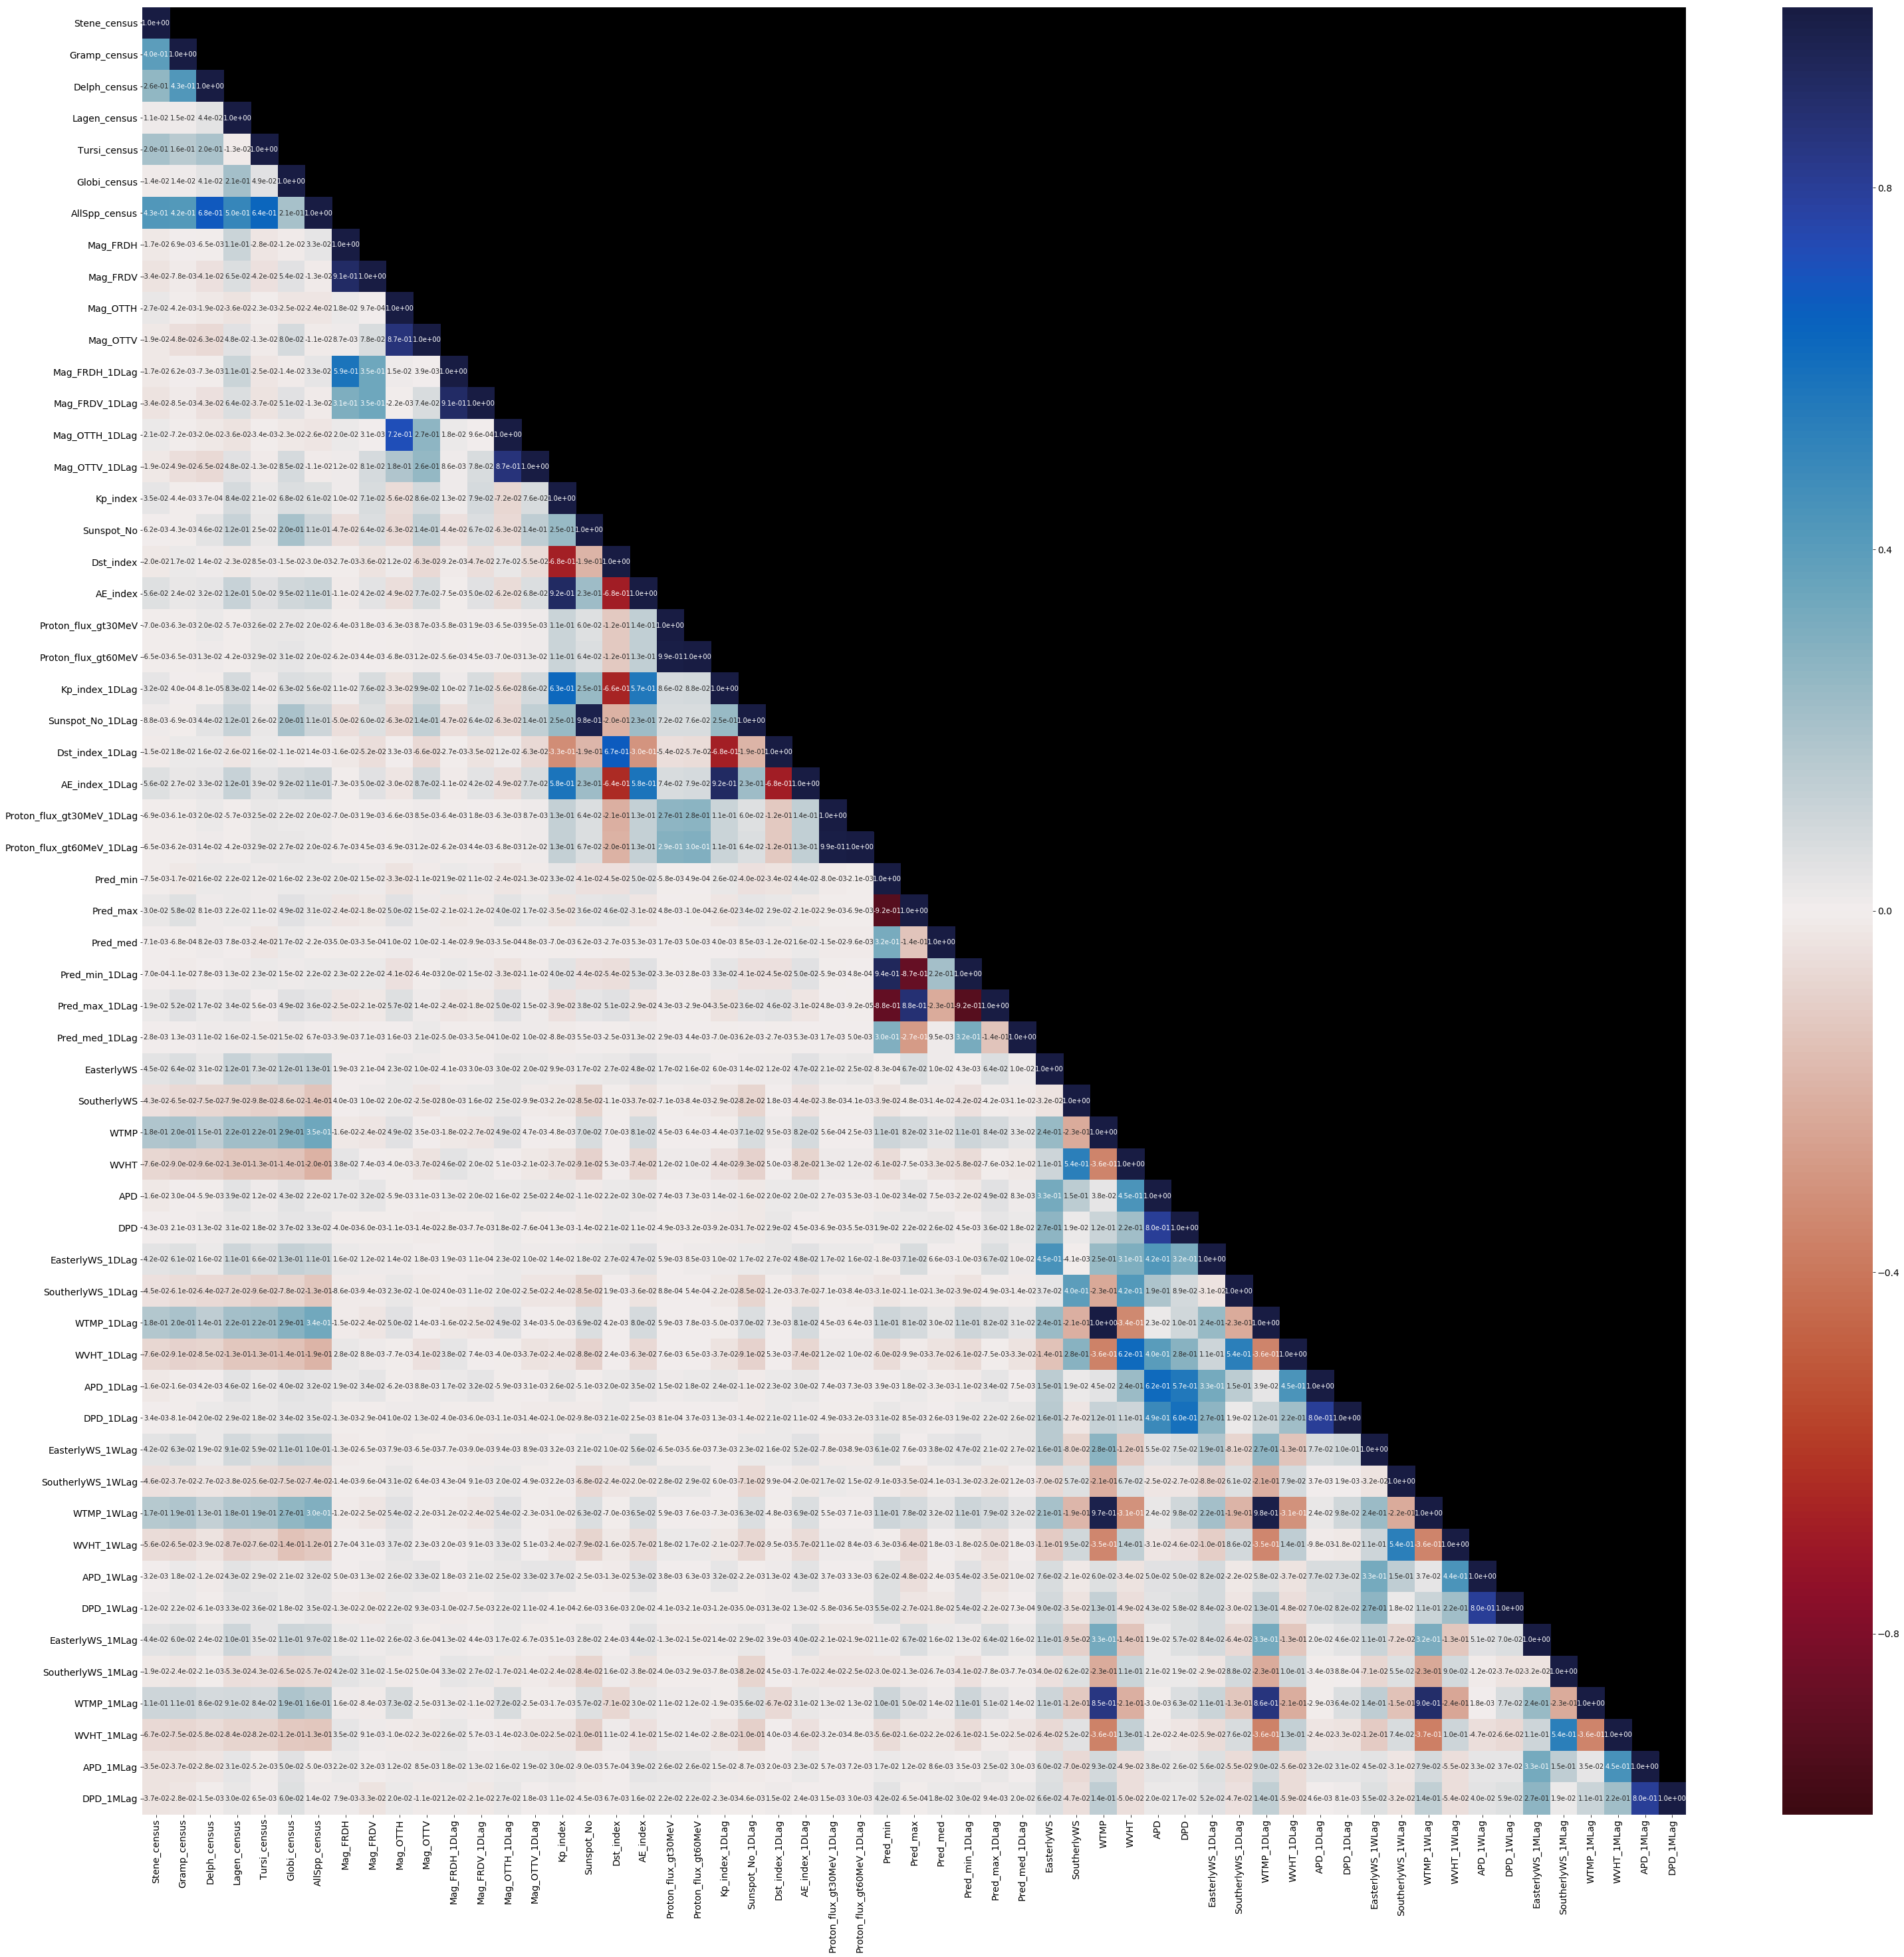

In [52]:
f, ax = pl.subplots(figsize=(52, 50))
ax.set_facecolor('black')
heatmap(dfCorr, ax=ax, vmin=-1, vmax=1, mask=np.triu(np.ones([dfCorr.shape[1]]*2), k=1),
       cmap=cmo.balance_r, annot=True, fmt='.1e')

In [53]:
f.savefig('../FigJar/Pairwise_All.png', dpi=300, orientation='landscape')